Using device: cpu
RNN for Shakespeare Text Generation
Loading Shakespeare dataset...
Loaded 10 Shakespeare passages
Total characters: 8,855
Sample text: To be, or not to be, that is the question:
Whether 'tis nobler in the mind to suffer
The slings and arrows of outrageous fortune,
Or to take arms against a sea of troubles
And by opposing end them. To...
Building vocabulary...
Vocabulary size: 219
Most common words: [('and', 82), ('the', 80), ('of', 52), ('to', 39), ('a', 38), ('that', 33), ('is', 29), ('in', 26), ('it', 23), ('s', 20)]
Training texts: 8
Validation texts: 2
Total tokens: 1499
Total tokens: 186

Model Architecture:
RNNModel(
  (embedding): Embedding(219, 128)
  (rnn): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=219, bias=True)
)

Total parameters: 1,005,915
Training RNN for 10 epochs...
Epoch [1/10], Step [0/46], Loss: 5.3799
Epoch [1/10] - Average Loss: 4.2714
Epoch 

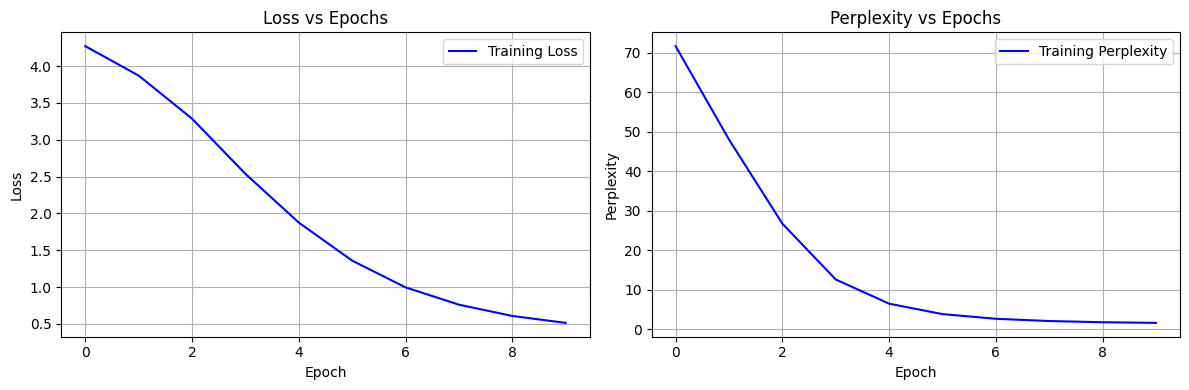


TEXT GENERATION EXAMPLES
Seed: 'To be or not to'
Generated: 'to be or not to <UNK> <UNK> or <UNK> to the <UNK> for <UNK> of <UNK> parts and <UNK> no'

Seed: 'Romeo Romeo wherefore'
Generated: 'romeo romeo wherefore thy name and for that maid which is no part of by take all any'

Seed: 'All the world's a'
Generated: 'all the world s a stage and all the men and <UNK> <UNK> <UNK> they have their <UNK> and their'

Seed: 'To thine own self'
Generated: 'to thine own self be doth the <UNK> <UNK> spirit to his full <UNK> on on you <UNK> english'

Seed: 'What light through yonder'
Generated: 'what light through yonder <UNK> <UNK> again is <UNK> <UNK> did his <UNK> <UNK> <UNK> with his <UNK> and'


=== RNN Ablation Study ===
Loading Shakespeare dataset...
Loaded 10 Shakespeare passages
Total characters: 8,855
Sample text: To be, or not to be, that is the question:
Whether 'tis nobler in the mind to suffer
The slings and arrows of outrageous fortune,
Or to take arms against a sea of troubles
And

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter
import math

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class TextDataset(Dataset):
    """
    Custom dataset for text data
    """
    def __init__(self, texts, vocab, sequence_length=50):
        self.vocab = vocab
        self.vocab_to_int = {word: i for i, word in enumerate(vocab)}
        self.int_to_vocab = {i: word for i, word in enumerate(vocab)}
        self.sequence_length = sequence_length

        # Convert text to integers
        self.encoded_texts = []
        for text in texts:
            words = self.tokenize(text)
            encoded = [self.vocab_to_int.get(word, self.vocab_to_int['<UNK>']) for word in words]
            self.encoded_texts.extend(encoded)

        print(f"Total tokens: {len(self.encoded_texts)}")

    def tokenize(self, text):
        """Simple tokenization"""
        # Convert to lowercase and split on whitespace and punctuation
        text = re.sub(r'[^\w\s]', ' ', text.lower())
        return text.split()

    def __len__(self):
        return len(self.encoded_texts) - self.sequence_length

    def __getitem__(self, idx):
        # Get sequence of tokens
        input_seq = torch.tensor(self.encoded_texts[idx:idx + self.sequence_length], dtype=torch.long)
        target_seq = torch.tensor(self.encoded_texts[idx + 1:idx + self.sequence_length + 1], dtype=torch.long)
        return input_seq, target_seq

class RNNModel(nn.Module):
    """
    RNN model for next-word prediction
    """
    def __init__(self, vocab_size, embedding_dim=128, hidden_size=256, num_layers=2,
                 dropout=0.5, rnn_type='LSTM'):
        super(RNNModel, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn_type = rnn_type

        # Embedding layer (trainable word embeddings)
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # RNN layer
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(embedding_dim, hidden_size, num_layers,
                              batch_first=True, dropout=dropout if num_layers > 1 else 0)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(embedding_dim, hidden_size, num_layers,
                             batch_first=True, dropout=dropout if num_layers > 1 else 0)
        else:
            self.rnn = nn.RNN(embedding_dim, hidden_size, num_layers,
                             batch_first=True, dropout=dropout if num_layers > 1 else 0)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Output layer
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        batch_size = x.size(0)

        # Embedding
        embedded = self.embedding(x)

        # RNN
        if hidden is None:
            rnn_out, hidden = self.rnn(embedded)
        else:
            rnn_out, hidden = self.rnn(embedded, hidden)

        # Apply dropout
        rnn_out = self.dropout(rnn_out)

        # Reshape for linear layer
        rnn_out = rnn_out.contiguous().view(-1, self.hidden_size)

        # Output layer
        output = self.fc(rnn_out)

        return output, hidden

    def init_hidden(self, batch_size):
        """Initialize hidden state"""
        weight = next(self.parameters()).data

        if self.rnn_type == 'LSTM':
            hidden = (weight.new(self.num_layers, batch_size, self.hidden_size).zero_(),
                     weight.new(self.num_layers, batch_size, self.hidden_size).zero_())
        else:
            hidden = weight.new(self.num_layers, batch_size, self.hidden_size).zero_()

        return hidden

def load_shakespeare_data():
    """
    Load Shakespeare dataset - fallback to built-in texts
    """
    print("Loading Shakespeare dataset...")

    # Comprehensive Shakespeare text collection
    shakespeare_texts = [
        """To be, or not to be, that is the question:
Whether 'tis nobler in the mind to suffer
The slings and arrows of outrageous fortune,
Or to take arms against a sea of troubles
And by opposing end them. To die—to sleep,
No more; and by a sleep to say we end
The heart-ache and the thousand natural shocks
That flesh is heir to: 'tis a consummation
Devoutly to be wish'd. To die, to sleep;
To sleep, perchance to dream—ay, there's the rub:
For in that sleep of death what dreams may come,
When we have shuffled off this mortal coil,
Must give us pause—there's the reason
That makes calamity of so long life. For who would bear the whips and scorns of time,
The oppressor's wrong, the proud man's contumely,
The pangs of despised love, the law's delay,
The insolence of office, and the spurns
That patient merit of th' unworthy takes,
When he himself might his quietus make
With a bare bodkin? Who would fardels bear,
To grunt and sweat under a weary life,
But that the dread of something after death,
The undiscovered country from whose bourn
No traveler returns, puzzles the will,
And makes us rather bear those ills we have
Than fly to others that we know not of?
Thus conscience does make cowards of us all,
And thus the native hue of resolution
Is sicklied o'er with the pale cast of thought,
And enterprises of great pitch and moment
With this regard their currents turn awry
And lose the name of action.""",

        """But soft, what light through yonder window breaks?
It is the east, and Juliet is the sun.
Arise, fair sun, and kill the envious moon,
Who is already sick and pale with grief
That thou, her maid, art far more fair than she.
Be not her maid since she is envious.
Her vestal livery is but sick and green,
And none but fools do wear it. Cast it off!
It is my lady; O, it is my love.
Oh, that she knew she were! She speaks, yet she says nothing.
What of that? Her eye discourses; I will answer it.
I am too bold; 'tis not to me she speaks.
Two of the fairest stars in all the heaven,
Having some business, do entreat her eyes
To twinkle in their spheres till they return.
What if her eyes were there, they in her head?
The brightness of her cheek would shame those stars
As daylight doth a lamp; her eyes in heaven
Would through the airy region stream so bright
That birds would sing and think it were not night.
See how she leans her cheek upon her hand.
Oh, that I were a glove upon that hand
That I might touch that cheek!""",

        """All the world's a stage,
And all the men and women merely players;
They have their exits and their entrances,
And one man in his time plays many parts,
His acts being seven ages. At first the infant,
Mewling and puking in the nurse's arms;
And then the whining schoolboy, with his satchel
And shining morning face, creeping like snail
Unwillingly to school. And then the lover,
Sighing like furnace, with a woeful ballad
Made to his mistress' eyebrow. Then a soldier,
Full of strange oaths and bearded like the pard,
Jealous in honor, sudden and quick in quarrel,
Seeking the bubble reputation
Even in the cannon's mouth. And then the justice,
In fair round belly with good capon lined,
With eyes severe and beard of formal cut,
Full of wise saws and modern instances;
And so he plays his part. The sixth age shifts
Into the lean and slippered pantaloon,
With spectacles on nose and pouch on side;
His youthful hose, well saved, a world too wide
For his shrunk shank, and his big manly voice,
Turning again toward childish treble, pipes
And whistles in his sound. Last scene of all,
That ends this strange eventful history,
Is second childishness and mere oblivion,
Sans teeth, sans eyes, sans taste, sans everything.""",

        """Tomorrow, and tomorrow, and tomorrow,
Creeps in this petty pace from day to day,
To the last syllable of recorded time;
And all our yesterdays have lighted fools
The way to dusty death. Out, out, brief candle!
Life's but a walking shadow, a poor player,
That struts and frets his hour upon the stage,
And then is heard no more. It is a tale
Told by an idiot, full of sound and fury,
Signifying nothing. She should have died hereafter.
There would have been a time for such a word.
Tomorrow, and tomorrow, and tomorrow,
Creeps in this petty pace from day to day
To the last syllable of recorded time,
And all our yesterdays have lighted fools
The way to dusty death. Out, out, brief candle!
Life's but a walking shadow, a poor player
That struts and frets his hour upon the stage
And then is heard no more. It is a tale
Told by an idiot, full of sound and fury,
Signifying nothing.""",

        """Romeo, Romeo, wherefore art thou Romeo?
Deny thy father and refuse thy name,
Or if thou wilt not, be but sworn my love,
And I'll no longer be a Capulet.
'Tis but thy name that is my enemy.
Thou art thyself, though not a Montague.
What's Montague? It is nor hand, nor foot,
Nor arm, nor face, nor any other part
Belonging to a man. O, be some other name!
What's in a name? That which we call a rose
By any other word would smell as sweet.
So Romeo would, were he not Romeo called,
Retain that dear perfection which he owes
Without that title. Romeo, doff thy name,
And for that name, which is no part of thee
Take all myself. I take thee at thy word.
Call me but love, and I'll be new baptized.
Henceforth I never will be Romeo. What man art thou that,
thus bescreened in night, so stumblest on my counsel?
By a name I know not how to tell thee who I am.
My name, dear saint, is hateful to myself
Because it is an enemy to thee.
Had I it written, I would tear the word.""",

        """Friends, Romans, countrymen, lend me your ears;
I come to bury Caesar, not to praise him.
The evil that men do lives after them;
The good is oft interred with their bones.
So let it be with Caesar. The noble Brutus
Hath told you Caesar was ambitious.
If it were so, it was a grievous fault,
And grievously hath Caesar answered it.
Here, under leave of Brutus and the rest—
For Brutus is an honorable man,
So are they all, all honorable men—
Come I to speak in Caesar's funeral.
He was my friend, faithful and just to me,
But Brutus says he was ambitious,
And Brutus is an honorable man.
He hath brought many captives home to Rome,
Whose ransoms did the general coffers fill.
Did this in Caesar seem ambitious?
When that the poor have cried, Caesar hath wept.
Ambition should be made of sterner stuff.
Yet Brutus says he was ambitious,
And Brutus is an honorable man.""",

        """Once more unto the breach, dear friends, once more,
Or close the wall up with our English dead.
In peace there's nothing so becomes a man
As modest stillness and humility,
But when the blast of war blows in our ears,
Then imitate the action of the tiger.
Stiffen the sinews, summon up the blood,
Disguise fair nature with hard-favored rage.
Then lend the eye a terrible aspect,
Let pry through the portage of the head
Like the brass cannon, let the brow o'erwhelm it
As fearfully as doth a galled rock
O'erhang and jutty his confounded base,
Swilled with the wild and wasteful ocean.
Now set the teeth and stretch the nostril wide,
Hold hard the breath and bend up every spirit
To his full height. On, on, you noblest English,
Whose blood is fet from fathers of war-proof,
Fathers that like so many Alexanders
Have in these parts from morn till even fought
And sheathed their swords for lack of argument.""",

        """If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the sweet sound,
That breathes upon a bank of violets,
Stealing and giving odour! Enough; no more:
'Tis not so sweet now as it was before.
O spirit of love! how quick and fresh art thou,
That, notwithstanding thy capacity
Receiveth as the sea, nought enters there,
Of what validity and pitch soe'er,
But falls into abatement and low price,
Even in a minute: so full of shapes is fancy
That it alone is high fantastical.""",

        """Now is the winter of our discontent
Made glorious summer by this sun of York;
And all the clouds that lour'd upon our house
In the deep bosom of the ocean buried.
Now are our brows bound with victorious wreaths;
Our bruised arms hung up for monuments;
Our stern alarums changed to merry meetings,
Our dreadful marches to delightful measures.
Grim-visaged war hath smooth'd his wrinkled front;
And now, instead of mounting barded steeds
To fright the souls of fearful adversaries,
He capers nimbly in a lady's chamber
To the lascivious pleasing of a lute.""",

        """Double, double toil and trouble;
Fire burn and caldron bubble.
Fillet of a fenny snake,
In the caldron boil and bake;
Eye of newt and toe of frog,
Wool of bat and tongue of dog,
Adder's fork and blind-worm's sting,
Lizard's leg and owlet's wing,
For a charm of powerful trouble,
Like a hell-broth boil and bubble.
Double, double toil and trouble;
Fire burn and caldron bubble.
Cool it with a baboon's blood,
Then the charm is firm and good."""
    ]

    print(f"Loaded {len(shakespeare_texts)} Shakespeare passages")
    total_chars = sum(len(text) for text in shakespeare_texts)
    print(f"Total characters: {total_chars:,}")
    print(f"Sample text: {shakespeare_texts[0][:200]}...")

    return shakespeare_texts

def build_vocabulary(texts, min_freq=2):
    """
    Build vocabulary from texts
    """
    print("Building vocabulary...")

    # Tokenize all texts
    all_words = []
    for text in texts:
        words = re.sub(r'[^\w\s]', ' ', text.lower()).split()
        all_words.extend(words)

    # Count word frequencies
    word_counts = Counter(all_words)

    # Create vocabulary with minimum frequency threshold
    vocab = ['<PAD>', '<UNK>', '<START>', '<END>']  # Special tokens
    vocab.extend([word for word, count in word_counts.items() if count >= min_freq])

    print(f"Vocabulary size: {len(vocab)}")
    print(f"Most common words: {word_counts.most_common(10)}")

    return vocab

def train_model(model, train_loader, criterion, optimizer, num_epochs=10, clip_grad=5.0):
    """
    Train the RNN model
    """
    model.train()
    train_losses = []

    print(f"Training RNN for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        hidden = model.init_hidden(train_loader.batch_size)
        running_loss = 0.0
        batch_count = 0

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            batch_size = inputs.size(0)

            # Skip if batch size doesn't match (last batch might be smaller)
            if batch_size != train_loader.batch_size:
                continue

            inputs, targets = inputs.to(device), targets.to(device)

            # Detach hidden state (prevent backprop through entire dataset)
            if isinstance(hidden, tuple):
                hidden = (hidden[0].detach(), hidden[1].detach())
            else:
                hidden = hidden.detach()

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs, hidden = model(inputs, hidden)

            # Reshape targets to match outputs
            targets = targets.contiguous().view(-1)

            # Calculate loss
            loss = criterion(outputs, targets)

            # Backward pass
            loss.backward()

            # Clip gradients to prevent exploding gradients
            nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

            # Update weights
            optimizer.step()

            running_loss += loss.item()
            batch_count += 1

            if batch_idx % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}')

        avg_loss = running_loss / batch_count
        train_losses.append(avg_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}] - Average Loss: {avg_loss:.4f}')

        # Calculate perplexity
        perplexity = math.exp(avg_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}] - Perplexity: {perplexity:.2f}')

    return train_losses

def evaluate_model(model, val_loader, criterion):
    """
    Evaluate the model and calculate perplexity
    """
    model.eval()
    total_loss = 0.0
    batch_count = 0

    with torch.no_grad():
        hidden = model.init_hidden(val_loader.batch_size)

        for inputs, targets in val_loader:
            batch_size = inputs.size(0)

            if batch_size != val_loader.batch_size:
                continue

            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs, hidden = model(inputs, hidden)

            # Reshape targets
            targets = targets.contiguous().view(-1)

            # Calculate loss
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            batch_count += 1

    avg_loss = total_loss / batch_count
    perplexity = math.exp(avg_loss)

    print(f'Validation Loss: {avg_loss:.4f}')
    print(f'Validation Perplexity: {perplexity:.2f}')

    return avg_loss, perplexity

def generate_text(model, dataset, seed_text="To be or not to", max_length=20, temperature=1.0):
    """
    Generate text using the trained model
    """
    model.eval()

    # Tokenize seed text
    words = dataset.tokenize(seed_text)

    # Convert to integers
    input_seq = [dataset.vocab_to_int.get(word, dataset.vocab_to_int['<UNK>']) for word in words]

    # Generate text
    generated_words = words.copy()
    hidden = model.init_hidden(1)

    with torch.no_grad():
        for _ in range(max_length):
            # Convert current sequence to tensor
            input_tensor = torch.tensor([input_seq], dtype=torch.long).to(device)

            # Forward pass
            outputs, hidden = model(input_tensor, hidden)

            # Get last output (prediction for next word)
            last_output = outputs[-1]

            # Apply temperature
            if temperature != 1.0:
                last_output = last_output / temperature

            # Convert to probabilities
            probabilities = F.softmax(last_output, dim=0)

            # Sample from distribution
            predicted_idx = torch.multinomial(probabilities, 1).item()

            # Convert back to word
            predicted_word = dataset.int_to_vocab[predicted_idx]

            # Add to generated text
            generated_words.append(predicted_word)

            # Update input sequence (sliding window)
            input_seq.append(predicted_idx)
            if len(input_seq) > 50:  # Keep same sequence length as training
                input_seq = input_seq[-50:]

    return ' '.join(generated_words)

def plot_training_curves(train_losses, val_losses=None):
    """
    Plot training curves
    """
    plt.figure(figsize=(12, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, 'b-', label='Training Loss')
    if val_losses:
        plt.plot(val_losses, 'r-', label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot perplexity
    plt.subplot(1, 2, 2)
    train_perplexity = [math.exp(loss) for loss in train_losses]
    plt.plot(train_perplexity, 'b-', label='Training Perplexity')
    if val_losses:
        val_perplexity = [math.exp(loss) for loss in val_losses]
        plt.plot(val_perplexity, 'r-', label='Validation Perplexity')
    plt.title('Perplexity vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def ablation_study():
    """
    Conduct ablation study on RNN components
    """
    print("\n=== RNN Ablation Study ===")

    # Load data once
    text_data = load_shakespeare_data()
    vocab = build_vocabulary(text_data)

    # Split data
    train_size = int(0.8 * len(text_data))
    train_texts = text_data[:train_size]
    val_texts = text_data[train_size:]

    train_dataset = TextDataset(train_texts, vocab)
    val_dataset = TextDataset(val_texts, vocab)

    results = []

    # Test different hidden sizes
    hidden_sizes = [128, 256, 512]
    print("\n--- Testing Hidden Sizes ---")

    for hidden_size in hidden_sizes:
        print(f"\nTesting Hidden Size: {hidden_size}")

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

        model = RNNModel(len(vocab), hidden_size=hidden_size, num_layers=2).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Train for fewer epochs
        train_losses = train_model(model, train_loader, criterion, optimizer, num_epochs=3)
        val_loss, val_perplexity = evaluate_model(model, val_loader, criterion)

        results.append({
            'component': 'Hidden Size',
            'value': hidden_size,
            'val_loss': val_loss,
            'val_perplexity': val_perplexity
        })

    # Test different RNN types
    rnn_types = ['RNN', 'LSTM', 'GRU']
    print("\n--- Testing RNN Types ---")

    for rnn_type in rnn_types:
        print(f"\nTesting RNN Type: {rnn_type}")

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

        model = RNNModel(len(vocab), hidden_size=256, num_layers=2, rnn_type=rnn_type).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        train_losses = train_model(model, train_loader, criterion, optimizer, num_epochs=3)
        val_loss, val_perplexity = evaluate_model(model, val_loader, criterion)

        results.append({
            'component': 'RNN Type',
            'value': rnn_type,
            'val_loss': val_loss,
            'val_perplexity': val_perplexity
        })

    return results

def print_ablation_results(results):
    """
    Print ablation study results
    """
    print("\n" + "="*60)
    print("RNN ABLATION STUDY RESULTS")
    print("="*60)
    print(f"{'Component':<15} {'Value':<10} {'Val Loss':<10} {'Perplexity':<10}")
    print("-"*60)

    for result in results:
        print(f"{result['component']:<15} {str(result['value']):<10} {result['val_loss']:<10.4f} "
              f"{result['val_perplexity']:<10.2f}")

def main():
    """
    Main function to run the complete RNN pipeline
    """
    print("RNN for Shakespeare Text Generation")
    print("="*50)

    # Load and preprocess data
    text_data = load_shakespeare_data()
    vocab = build_vocabulary(text_data)

    # Split data into train/validation
    train_size = int(0.8 * len(text_data))
    train_texts = text_data[:train_size]
    val_texts = text_data[train_size:]

    print(f"Training texts: {len(train_texts)}")
    print(f"Validation texts: {len(val_texts)}")

    # Create datasets
    train_dataset = TextDataset(train_texts, vocab, sequence_length=50)
    val_dataset = TextDataset(val_texts, vocab, sequence_length=50)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

    # Initialize model
    model = RNNModel(len(vocab), embedding_dim=128, hidden_size=256,
                    num_layers=2, dropout=0.5, rnn_type='LSTM').to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print(f"\nModel Architecture:")
    print(model)
    print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Train model
    train_losses = train_model(model, train_loader, criterion, optimizer, num_epochs=10)

    # Evaluate model
    val_loss, val_perplexity = evaluate_model(model, val_loader, criterion)

    # Plot training curves
    plot_training_curves(train_losses)

    # Generate text samples
    print(f"\n" + "="*50)
    print("TEXT GENERATION EXAMPLES")
    print("="*50)

    seed_phrases = [
        "To be or not to",
        "Romeo Romeo wherefore",
        "All the world's a",
        "To thine own self",
        "What light through yonder"
    ]

    for seed in seed_phrases:
        generated = generate_text(model, train_dataset, seed, max_length=15)
        print(f"Seed: '{seed}'")
        print(f"Generated: '{generated}'")
        print()

    # Conduct ablation study
    ablation_results = ablation_study()
    print_ablation_results(ablation_results)

    # Final metrics
    print(f"\n" + "="*50)
    print("FINAL MODEL PERFORMANCE")
    print("="*50)
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Perplexity: {val_perplexity:.2f}")
    print(f"Vocabulary Size: {len(vocab)}")

if __name__ == "__main__":
    main()